In [17]:
import torch

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import random_split
from sklearn.metrics import classification_report

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt

import numpy as np

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout2d(p=0.1)
        )
    
    # For future use, not needed for MNIST dataset
#     self.conv_layer3 = nn.Sequential(
#         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
#         nn.BatchNorm2d(256),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
#         nn.ReLU(inplace=True)
#         nn.MaxPool2d(kernel_size=2, stride=2)
#         nn.Dropout2d(p=0.1)
#     )
    
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=2048, out_features=512), # Where 1792? Where 28?
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.1),
            nn.Linear(in_features=256, out_features=10)
        )

    def forward(self, x):
        x = self.conv_layer1(x)

        x = self.conv_layer2(x)

        #     x = self.conv_layer3(x)

        #x = F.flatten(X) # Maybe replace with .view
        #x = x.view(-1, 131072) # Where 131072 - 128^2 * (8?)
        #x = torch.flatten(x, 1)
        x = x.view(x.size(0), -1)
        #x = torch.flatten(x, 1)

        x = self.fc_layer(x)

        return F.log_softmax(x, dim=1)
        

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear

In [19]:
def train(model, train_dataloader, val_dataloader, loss_function, optimizer, train_steps, val_steps, history):
    model.train()

    total_train_loss = 0
    total_val_loss = 0

    total_train_correct = 0
    total_val_correct = 0

    for (X, y) in train_dataloader:
        (X, y) = (X.to(device), y.to(device))

        # Where to put...
        optimizer.zero_grad()

        pred = model(X)
        loss = loss_function(pred, y)

        loss.backward()
        optimizer.step()

        total_train_loss += loss
        total_train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    with torch.no_grad():
        model.eval()

        for (X, y) in val_dataloader:
            (X, y) = (X.to(device), y.to(device))

            pred = model(X)
            loss = loss_function(pred, y)

            total_val_loss += loss
            total_val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()


    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    train_correct = total_train_correct / len(train_dataloader.dataset)
    val_correct = total_val_correct / len(val_dataloader.dataset)

    history["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    history["train_acc"].append(train_correct)
    history["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    history["val_acc"].append(val_correct)

    return history

In [20]:
def test_normal(model, test_dataloader, loss_function, test_data):
    model.eval()

    total_test_loss = 0
    total_test_correct = 0
    preds = []
    
    examples = []
    
    for (X, y) in test_dataloader:
        (X, y) = (X.to(device), y.to(device))

        pred = model(X)
        loss = loss_function(pred, y)

        total_test_loss += loss
        total_test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        preds.extend(pred.argmax(axis=1).cpu().numpy())
        
        if len(examples) < 5:
            examples.append( (pred, X.squeeze().detach().cpu().numpy()) )

    #cr = classification_report(test_data.targets.cpu().numpy(), np.array(preds), target_names=test_data.classes)
    cr = classification_report(test_data.targets, np.array(preds), target_names=test_data.classes)

    return cr, examples

In [21]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()

    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [22]:
def test_attack(model, test_dataloader, loss_function, test_data, epsilon):
    model.eval()

    total_test_loss = 0
    total_test_correct = 0
    preds = []
    
    examples = []
    
    for (X, y) in test_dataloader:
        (X, y) = (X.to(device), y.to(device))
        
        X.requires_grad = True

        init_pred = model(X)
        init_loss = loss_function(init_pred, y)
        
        model.zero_grad()
        init_loss.backward()
        
        X_grad = X.grad.data
        X_denorm = denorm(X)
        
        X_attack = fgsm_attack(X_denorm, epsilon, X_grad)
        X_attack_normalized = transforms.Normalize((0.137,), (0.3081,))(X_attack)
        attack_pred = model(X_attack_normalized)
        
        attack_loss = loss_function(attack_pred, y)

        total_test_loss += attack_loss
        total_test_correct += (attack_pred.argmax(1) == y).type(torch.float).sum().item()

        preds.extend(attack_pred.argmax(axis=1).cpu().numpy())
        
        if len(examples) < 5:
            examples.append( (init_pred, attack_pred, X.squeeze().detach().cpu().numpy()) )

    #cr = classification_report(test_data.targets.cpu().numpy(), np.array(preds), target_names=test_data.classes)
    cr = classification_report(test_data.targets, np.array(preds), target_names=test_data.classes)

    return cr, examples

In [23]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 3

TRAIN_SPLIT = 0.8
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
loss_function = nn.NLLLoss()
#loss_function = torch.nn.CrossEntropyLoss()

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [25]:
# For now remove SSL certification because is not working
# Remove when SSL cert is working
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [26]:
train_data_init = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
# train_data_init = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
# test_data = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())

train_sample_size = int(len(train_data_init) * TRAIN_SPLIT)
#val_sample_size = int(len(train_data_init) * VAL_SPLIT)
val_sample_size = len(train_data_init) - train_sample_size
train_data, val_data = random_split(train_data_init, [train_sample_size, val_sample_size], generator=torch.Generator().manual_seed(42)) # manual seed for reproducability

In [27]:
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE)

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE
test_steps = len(test_dataloader.dataset) // BATCH_SIZE

classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")

In [28]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print("-"*50)

for X, y in val_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print("-"*50)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [29]:
# def show_images(img, one_channel=True):
#     if one_channel:
#         img = img.mean(dim=0)

#     img = img / 2 + 0.5 # unnormalize? (what does it mean)
#     #np_img = img.numpy()

#     if one_channel:
#         plt.imshow(img, cmap="Greys")
#     else:
#         plt.imshow(np.transpose(img, (1, 2, 0)))

# dataiter = iter(train_dataloader)
# images, labels = next(dataiter)
# images = images.numpy()

# %matplotlib inline

# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#     show_images(images[idx])
#     ax.set_title(classes[labels[idx]])

In [30]:
for e in range(EPOCHS):
    print(f"Epoch {e+1}")
    print(train(model, train_dataloader, val_dataloader, loss_function, optimizer, train_steps, val_steps, history))
    print("-"*50)

# cr, examples = test_normal(model, test_dataloader, loss_function, test_data)
# print(cr)

Epoch 1


KeyboardInterrupt: 

In [ ]:
cr, examples = test_normal(model, test_dataloader, loss_function, test_data)
print(cr)

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99      5923
     1 - one       1.00      0.99      0.99      6742
     2 - two       0.99      0.99      0.99      5958
   3 - three       1.00      0.99      0.99      6131
    4 - four       0.99      0.99      0.99      5842
    5 - five       0.99      0.99      0.99      5421
     6 - six       0.99      1.00      1.00      5918
   7 - seven       0.96      1.00      0.98      6265
   8 - eight       1.00      0.98      0.99      5851
    9 - nine       0.99      0.98      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



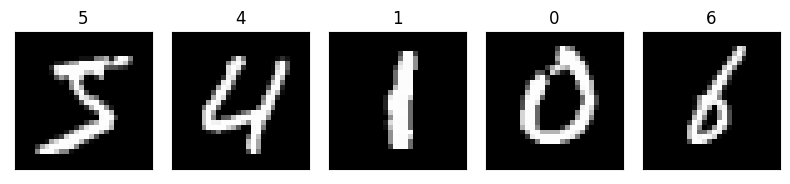

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(examples)):
    cnt += 1
    plt.subplot(1, 5, cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    preds, img = examples[i]
    #plt.title(f"{(preds[i].max(0, keepdim=True)[1]).item()}")
    plt.title(f"{preds.argmax(1)[0]}")
    plt.imshow(img[0,:,:], cmap="gray")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99      5923
     1 - one       1.00      0.99      0.99      6742
     2 - two       0.99      0.99      0.99      5958
   3 - three       1.00      0.99      0.99      6131
    4 - four       0.99      0.99      0.99      5842
    5 - five       0.99      0.99      0.99      5421
     6 - six       1.00      1.00      1.00      5918
   7 - seven       0.96      1.00      0.98      6265
   8 - eight       1.00      0.98      0.99      5851
    9 - nine       0.99      0.98      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



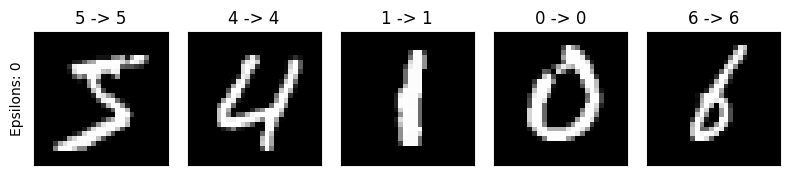

              precision    recall  f1-score   support

    0 - zero       0.79      0.72      0.75      5923
     1 - one       0.68      0.10      0.17      6742
     2 - two       0.44      0.49      0.46      5958
   3 - three       0.56      0.51      0.53      6131
    4 - four       0.43      0.34      0.38      5842
    5 - five       0.45      0.39      0.42      5421
     6 - six       0.74      0.55      0.63      5918
   7 - seven       0.25      0.71      0.37      6265
   8 - eight       0.41      0.38      0.39      5851
    9 - nine       0.07      0.05      0.06      5949

    accuracy                           0.42     60000
   macro avg       0.48      0.42      0.42     60000
weighted avg       0.48      0.42      0.41     60000



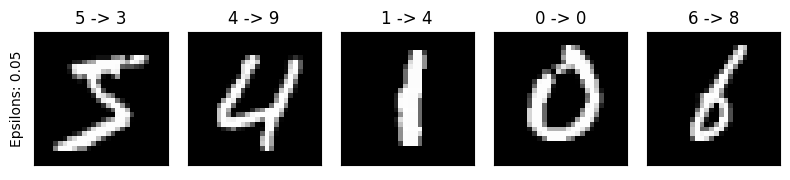

              precision    recall  f1-score   support

    0 - zero       0.27      0.09      0.13      5923
     1 - one       0.00      0.00      0.00      6742
     2 - two       0.12      0.16      0.14      5958
   3 - three       0.06      0.03      0.04      6131
    4 - four       0.04      0.02      0.02      5842
    5 - five       0.00      0.00      0.00      5421
     6 - six       0.01      0.00      0.00      5918
   7 - seven       0.01      0.02      0.01      6265
   8 - eight       0.04      0.14      0.06      5851
    9 - nine       0.00      0.00      0.00      5949

    accuracy                           0.05     60000
   macro avg       0.06      0.05      0.04     60000
weighted avg       0.06      0.05      0.04     60000



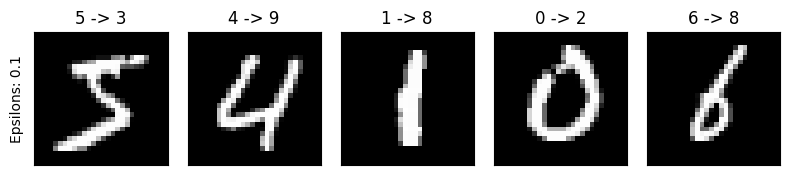

              precision    recall  f1-score   support

    0 - zero       0.01      0.00      0.00      5923
     1 - one       0.00      0.00      0.00      6742
     2 - two       0.12      0.15      0.13      5958
   3 - three       0.01      0.00      0.00      6131
    4 - four       0.01      0.00      0.00      5842
    5 - five       0.00      0.00      0.00      5421
     6 - six       0.00      0.00      0.00      5918
   7 - seven       0.00      0.00      0.00      6265
   8 - eight       0.04      0.26      0.08      5851
    9 - nine       0.00      0.00      0.00      5949

    accuracy                           0.04     60000
   macro avg       0.02      0.04      0.02     60000
weighted avg       0.02      0.04      0.02     60000



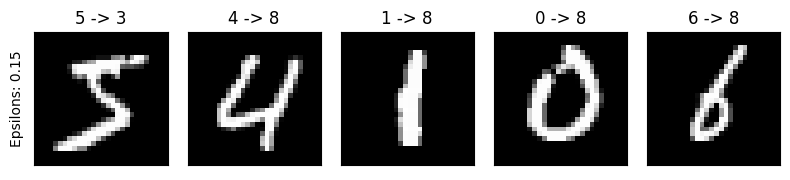

              precision    recall  f1-score   support

    0 - zero       0.00      0.00      0.00      5923
     1 - one       0.00      0.00      0.00      6742
     2 - two       0.16      0.14      0.15      5958
   3 - three       0.01      0.00      0.00      6131
    4 - four       0.01      0.00      0.00      5842
    5 - five       0.00      0.00      0.00      5421
     6 - six       0.00      0.00      0.00      5918
   7 - seven       0.00      0.00      0.00      6265
   8 - eight       0.07      0.51      0.12      5851
    9 - nine       0.00      0.00      0.00      5949

    accuracy                           0.06     60000
   macro avg       0.02      0.06      0.03     60000
weighted avg       0.02      0.06      0.03     60000



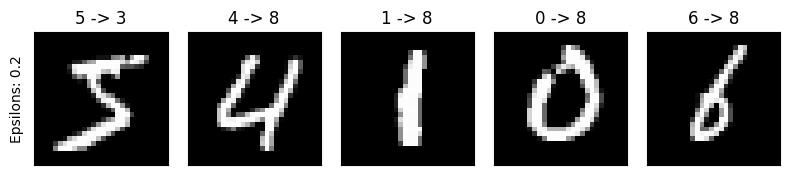

C:\Users\alica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334

              precision    recall  f1-score   support

    0 - zero       0.00      0.00      0.00      5923
     1 - one       0.00      0.00      0.00      6742
     2 - two       0.20      0.13      0.16      5958
   3 - three       0.01      0.00      0.00      6131
    4 - four       0.01      0.00      0.00      5842
    5 - five       0.00      0.00      0.00      5421
     6 - six       0.00      0.00      0.00      5918
   7 - seven       0.00      0.00      0.00      6265
   8 - eight       0.08      0.73      0.15      5851
    9 - nine       0.00      0.00      0.00      5949

    accuracy                           0.08     60000
   macro avg       0.03      0.09      0.03     60000
weighted avg       0.03      0.08      0.03     60000



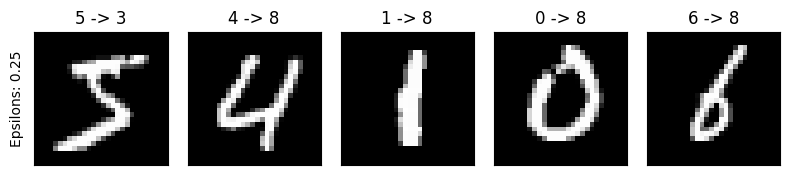

C:\Users\alica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334

              precision    recall  f1-score   support

    0 - zero       0.00      0.00      0.00      5923
     1 - one       0.00      0.00      0.00      6742
     2 - two       0.25      0.11      0.15      5958
   3 - three       0.03      0.00      0.00      6131
    4 - four       0.04      0.00      0.00      5842
    5 - five       0.00      0.00      0.00      5421
     6 - six       0.00      0.00      0.00      5918
   7 - seven       0.00      0.00      0.00      6265
   8 - eight       0.09      0.85      0.16      5851
    9 - nine       0.00      0.00      0.00      5949

    accuracy                           0.09     60000
   macro avg       0.04      0.10      0.03     60000
weighted avg       0.04      0.09      0.03     60000



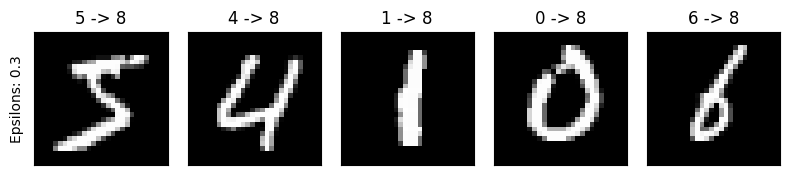

In [ ]:
epsilons = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3]
for eps in epsilons:
    cr, examples = test_attack(model, test_dataloader, loss_function, test_data, eps)
    print(cr)
    
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(examples)):
        cnt += 1
        plt.subplot(1, 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        init_preds, attack_preds, img = examples[i]
        if i == 0:
            plt.ylabel(f"Epsilons: {eps}")
        plt.title(f"{(init_preds.argmax(1)[0])} -> {(attack_preds.argmax(1)[0])}")
        plt.imshow(img[0,:,:], cmap="gray")
    plt.tight_layout()
    plt.show()

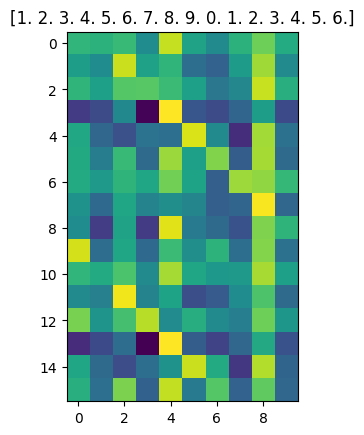

In [32]:
import torch
import matplotlib.pyplot as plt
image_tensor = torch.Tensor([[-2.7405, -2.8634, -2.6049, -4.1019, -0.7500, -3.3853, -4.1889, -2.8713,
         -1.8037, -3.0958],
        [-3.4965, -4.1056, -0.6902, -3.4309, -2.7710, -5.0686, -5.4433, -3.5725,
         -1.1962, -4.1497],
        [-2.7748, -3.4666, -2.1219, -2.1057, -2.5598, -3.4843, -4.7907, -4.2808,
         -0.7272, -2.9666],
        [-6.5359, -6.1278, -4.2319, -7.8170, -0.0623, -5.7989, -6.1131, -5.3489,
         -3.5167, -6.1332],
        [-3.1934, -5.3056, -5.9523, -4.9178, -5.0283, -0.5206, -4.1703, -6.8857,
         -1.1401, -4.9484],
        [-3.1571, -4.5798, -2.6176, -5.2062, -1.2382, -3.4744, -1.5411, -5.5968,
         -1.1257, -5.1914],
        [-3.0967, -3.6589, -2.8114, -3.2930, -1.7477, -3.3722, -5.5208, -1.2071,
         -1.3765, -2.6917],
        [-3.9202, -5.2179, -3.2840, -4.4052, -4.0295, -4.3327, -5.5296, -5.3550,
         -0.1272, -5.3240],
        [-4.0922, -6.4769, -3.3772, -6.5109, -0.4134, -4.6729, -5.2042, -5.9427,
         -1.5783, -2.7979],
        [-0.5804, -5.1068, -3.2618, -5.2414, -2.5466, -4.0353, -2.8296, -5.0590,
         -1.5039, -4.9662],
        [-2.7523, -3.1114, -2.2901, -4.1775, -1.1230, -3.3073, -3.7379, -3.6772,
         -1.1002, -3.4646],
        [-4.1386, -4.4843, -0.2309, -4.3880, -3.3642, -6.0336, -5.6605, -4.0869,
         -2.2666, -5.1911],
        [-1.6277, -3.8560, -2.3912, -0.8952, -4.1140, -3.0295, -4.1429, -4.5428,
         -1.7849, -3.7546],
        [-6.9130, -6.1574, -5.1072, -7.9082, -0.0663, -5.5865, -6.3062, -5.3255,
         -3.1807, -5.9417],
        [-3.2849, -5.1939, -6.0443, -5.0681, -3.8887, -0.6889, -3.1035, -6.6377,
         -0.9809, -5.3940],
        [-2.9443, -5.0553, -1.6064, -5.4655, -0.7705, -4.6463, -2.1422, -5.4289,
         -1.9875, -5.3087]])
label = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

plt.title(f"{label.cpu().numpy()}")
plt.imshow(image_tensor[:,:].cpu().numpy())
plt.show()



In [ ]:
for X, y in train_dataloader:
    plt.title(f"{y.argmax(1)[0]}")
    plt.imshow(X[0,:,:], cmap="gray")

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

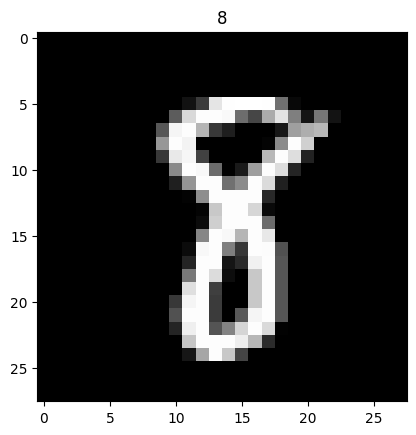

In [16]:
for X, y in train_dataloader:
    plt.title(f"{y[0]}")
    plt.imshow(X.squeeze().detach().cpu().numpy()[0,:,:], cmap="gray")